In [1]:
import numpy as np
import pickle, os, glob, io, sys
import tensorflow as tf
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage import io as skio
from skimage.transform import resize as sk_resize
import matplotlib.pyplot as plt

# Conv Net Class
- Supports loading or training a new conv net
- Architecture: Conv/Maxpool(7x7x32) - Conv/Maxpool(5x5x64) - Conv/Maxpool(3x3x128) - Conv/Maxpool(3x3x256) - Dense(512) - Dense(512)
- Preprocessing: Downsizes images to 60x80 pixels and adds a 4th channel containing edges

In [2]:
class JohnNet:
    
    def __init__(self):
        self.labels = None
        self.label_map = ['bart','homer','marge','lisa']
        
        if not os.path.exists('model/'):
            os.mkdir('model/')
        
        if os.path.isfile('features.p') and os.path.isfile('labels.p'):
            print('Reading cached files')
            self.features = self.__load('features.p')
            self.labels = self.__load('labels.p')
        else:
            self.__pre_process_images('images')
        
    @staticmethod
    def __load(path):
        with open(path, 'rb') as f:
            return pickle.load(f)
        
    @staticmethod
    def __save(obj, path):
        with open(path, 'wb') as f:
            return pickle.dump(obj, f)
        
    @staticmethod
    def __delete_dir(path):
        files = glob.glob(path)
        for f in files:
            os.remove(f)
    
    @staticmethod    
    def __load_image(path):
        img = skio.imread(path)
        shape = img.shape
    
        edges = np.reshape(sobel(rgb2gray(img)), (shape[0], shape[1], 1))
        img = np.concatenate([img, edges], axis=2) / 255
        
        img = sk_resize(img, (60, 80))
        
        return img

        
    def __pre_process_images(self, source):
        from sklearn.model_selection import train_test_split
        
        labels = []
        features = []

        for file in glob.iglob('{}/*_*.jpg'.format(source)):
            label = file.split('_')[1].replace('.jpg','')
            labels.append(self.label_map.index(label))

            features.append(self.__load_image(file))

        #One hot encode labels
        labels = np.array(labels)
        labels_eye = np.eye(len(self.label_map))

        self.labels = labels_eye[labels]
        self.features = np.array(features)

        # Shuffle lists
        idx = np.arange(len(self.labels))
        np.random.shuffle(idx)
        self.labels = self.labels[idx]
        self.features = self.features[idx]


        self.__save(self.labels, 'labels.p')
        self.__save(self.features, 'features.p')
        
    def conv_maxpool(self, x, filters, kernel_size, strides, pool_size, pool_strides):
        conv = tf.layers.conv2d(x, filters=filters, kernel_size=kernel_size, strides=strides, 
                                 padding='SAME', activation=tf.nn.relu,
                                kernel_initializer = tf.truncated_normal_initializer(stddev=0.1))
        
        pool = tf.layers.max_pooling2d(conv, pool_size=pool_size, strides=pool_strides, padding='SAME')
        
        return pool
            
    def initialize_network(self):     
        self.__delete_dir('model/.*')
        
        tf.reset_default_graph()
        self.session = tf.Session()
        
        y_ = tf.placeholder(tf.float32, [None, 4], 'labels')
        x_ = tf.placeholder(tf.float32, [None, 60, 80, 4], 'features')
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
        conv_filters = [32, 64, 128, 256]
        conv_kernels = [(7,7), (5,5), (3,3), (3,3)]
        conv_strides = [(1,1), (1,1), (1,1), (1,1)]
        conv_padding = 'SAME'
        
        pool_size = [(2,2), (2,2), (2,2), (1,1)]
        pool_strides = [(2,2), (2,2), (2,2), (1,1)]
        pool_padding = 'SAME'
        
        dense_units = [1024, 512]
        dense_bias_init = None
        
        
        convpool1 = self.conv_maxpool(x_, filters=conv_filters[0], kernel_size=conv_kernels[0], strides=conv_strides[0],
                             pool_size=pool_size[0], pool_strides=pool_strides[0])
        
        convpool2 = self.conv_maxpool(convpool1, filters=conv_filters[1], kernel_size=conv_kernels[1], strides=conv_strides[1],
                             pool_size=pool_size[1], pool_strides=pool_strides[1])
        
        convpool3 = self.conv_maxpool(convpool2, filters=conv_filters[2], kernel_size=conv_kernels[2], strides=conv_strides[2],
                             pool_size=pool_size[2], pool_strides=pool_strides[2])
        
        convpool4 = self.conv_maxpool(convpool3, filters=conv_filters[3], kernel_size=conv_kernels[3], strides=conv_strides[3],
                             pool_size=pool_size[3], pool_strides=pool_strides[3])
            
        flat = tf.contrib.layers.flatten(convpool4)
        
        dense1 = tf.layers.dense(flat, units=dense_units[0], activation=tf.nn.relu, 
                                kernel_initializer = tf.truncated_normal_initializer(stddev=0.1))
        dense1_drop = tf.nn.dropout(dense1, keep_prob=keep_prob)
        
        dense2 = tf.layers.dense(flat, units=dense_units[1], activation=tf.nn.relu, 
                                kernel_initializer = tf.truncated_normal_initializer(stddev=0.1))
        dense2_drop = tf.nn.dropout(dense2, keep_prob=keep_prob)
        
        
        logits = tf.layers.dense(dense2_drop, 4)

        self.prediction = tf.nn.softmax(logits, name='prediction')
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,1), tf.argmax(y_,1)), tf.float32))
        
    def load_network(self, path):
        tf.reset_default_graph()
              

        self.session = tf.Session()
        loader = tf.train.import_meta_graph(path + '.meta')
        loader.restore(self.session, 'model/')
        self.prediction = tf.get_default_graph().get_tensor_by_name('prediction:0')

            
        
    def train_network(self, batch_size, epochs, test_size, shuffle_batch=True, path='model/'):
        from sklearn.model_selection import train_test_split
        
        with self.session as sess:
            sess.run(tf.global_variables_initializer())
            
            feat_train, feat_test, lab_train, lab_test = train_test_split(c.features, c.labels, test_size=test_size)

            for epoch in range(0, epochs):
                epoch_features = feat_train
                epoch_labels = lab_train

                if shuffle_batch:
                    idx = np.arange(len(epoch_features))
                    np.random.shuffle(idx)
                    epoch_labels = epoch_labels[idx]
                    epoch_features = epoch_features[idx]


                for batch in range(0, len(epoch_features), batch_size):
                    batch_end = batch + batch_size

                    batch_features = epoch_features[batch:batch_end]
                    batch_labels = epoch_labels[batch:batch_end]

                    sess.run(self.optimizer, feed_dict={'labels:0': batch_labels, 
                                                                         'features:0': batch_features, 
                                                                         'keep_prob:0': 0.5})

                    bcost = sess.run(self.cost, feed_dict={'labels:0': batch_labels, 
                                                                         'features:0': batch_features, 
                                                                         'keep_prob:0': 1.0})

                    bacc = sess.run(self.accuracy, feed_dict={'labels:0': batch_labels,
                                                          'features:0': batch_features, 
                                                          'keep_prob:0': 1.0})

                    sys.stdout.write('\rEpoch: {} | Batch: {} | Current loss: {:.3f} | Batch Acc: {:.2%}'.format(epoch, 
                                                                                                                 batch, bcost, bacc))
                    sys.stdout.flush()
                acce = sess.run(self.accuracy, feed_dict={'labels:0': lab_test,
                                              'features:0': feat_test, 
                                            'keep_prob:0': 1.0})

                print(' | Epoch {} Validation Accuracy: {:.2%}'.format(epoch, acce))
            saver = tf.train.Saver()
            save_path = saver.save(sess, path)
                

    def predict_images(self, num_sample):
        idx = np.random.choice(len(c.features), size=num_sample, replace=False)
        feat = self.features[idx]
        labels = self.labels[idx]
  
        predictions = self.session.run(self.prediction, feed_dict={'features:0': feat, 'keep_prob:0': 1.0})
    
        self.render_predictions(predictions, feat, labels )
    
    def render_predictions(self, predictions, images, labels):
        %matplotlib inline
        import math
        
        n = len(predictions)
        cols = 5
        rows = math.ceil((n*2)/cols)
        ratios = []
        for r in range(0, rows, 2):
            ratios.append(2)
            ratios.append(1)
            
        
        f, ax = plt.subplots(rows, cols,
                             figsize=(math.ceil(cols*2.5), math.ceil(rows*1.8)), gridspec_kw = {'height_ratios':ratios,
                                                                                            'hspace':0.01,
                                                                                               'wspace':0.8})
        
        r = -2
        for p in range(0, n):
            #r = math.floor(p/cols)
            c = p%cols
            
            if p%cols == 0:
                r+=2
                
            img = images[p]
            prediction = predictions[p]
                        
            ax[r,c].imshow(img[:,:,0:3])
            ax[r,c].tick_params(axis='both', left='off', bottom='off', labelbottom='off', labelleft='off')
            
            feat_true = np.argmax(labels[p])
            ax[r,c].set_title(self.label_map[feat_true])
            
            for l in range(0, 4):
                ax[r+1,c].barh(l, prediction[l])
                ax[r+1,c].text(prediction[l], l, '{:.1%}'.format(prediction[l]), va='center')
                
            ax[r+1,c].set_yticks(range(0, 4))
            ax[r+1,c].tick_params(axis='x', bottom='off', labelbottom='off')
            ax[r+1,c].set_yticklabels(self.label_map)

            ax[r+1,c].spines['right'].set_visible(False)
            ax[r+1,c].spines['bottom'].set_visible(False)
            ax[r+1,c].spines['top'].set_visible(False)
            ax[r+1,c].set_xlim([0,1.2])
        
        f.savefig('predictions.jpg',bbox_inches='tight', pad_inches=0)
          

# Construct the network

In [6]:
c = JohnNet()
c.initialize_network()

Reading cached files


# Train network for 1 epoch
Train for only one epoch to show the initial results

In [7]:
c.train_network(batch_size=128, epochs=1, test_size=0.3, shuffle_batch=True)

Epoch: 0 | Batch: 1664 | Current loss: 0.912 | Batch Acc: 66.23%% | Epoch 0 Validation Accuracy: 57.56%


# Load model to show predictions for 30 random images

INFO:tensorflow:Restoring parameters from model/


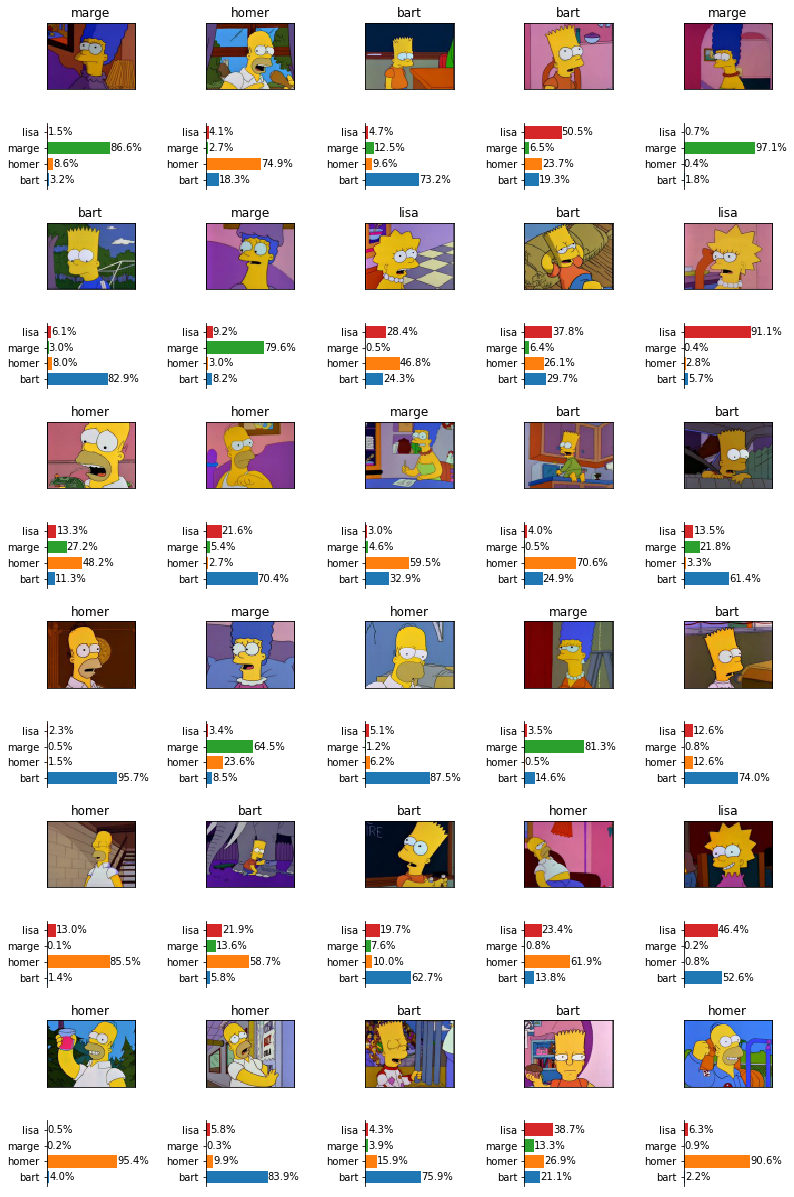

In [8]:
c.load_network('model/')
c.predict_images(30)

# Train network for 10 epochs

In [9]:
c.initialize_network()
c.train_network(batch_size=128, epochs=15, test_size=0.3, shuffle_batch=True)

Epoch: 0 | Batch: 1664 | Current loss: 1.450 | Batch Acc: 41.56%% | Epoch 0 Validation Accuracy: 43.64%
Epoch: 1 | Batch: 1664 | Current loss: 0.713 | Batch Acc: 76.62% | Epoch 1 Validation Accuracy: 68.14%
Epoch: 2 | Batch: 1664 | Current loss: 0.601 | Batch Acc: 83.12% | Epoch 2 Validation Accuracy: 73.36%
Epoch: 3 | Batch: 1664 | Current loss: 0.404 | Batch Acc: 84.42% | Epoch 3 Validation Accuracy: 80.05%
Epoch: 4 | Batch: 1664 | Current loss: 0.347 | Batch Acc: 89.61% | Epoch 4 Validation Accuracy: 84.07%
Epoch: 5 | Batch: 1664 | Current loss: 0.236 | Batch Acc: 94.81% | Epoch 5 Validation Accuracy: 87.55%
Epoch: 6 | Batch: 1664 | Current loss: 0.144 | Batch Acc: 96.10% | Epoch 6 Validation Accuracy: 89.29%
Epoch: 7 | Batch: 1664 | Current loss: 0.104 | Batch Acc: 98.70%% | Epoch 7 Validation Accuracy: 88.62%
Epoch: 8 | Batch: 1664 | Current loss: 0.056 | Batch Acc: 98.70%% | Epoch 8 Validation Accuracy: 90.63%
Epoch: 9 | Batch: 1664 | Current loss: 0.020 | Batch Acc: 100.00% | Ep

# Load trained model and show predictions for 30 images

INFO:tensorflow:Restoring parameters from model/


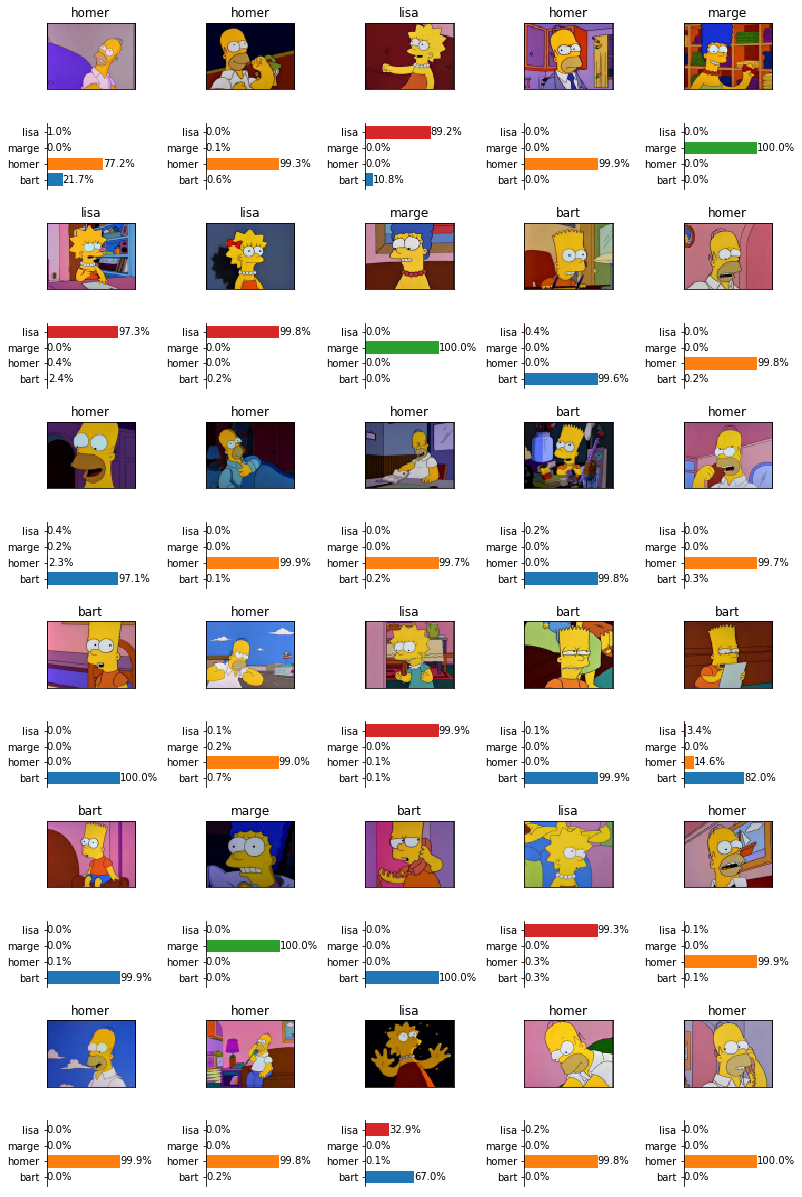

In [10]:
c.load_network('model/')
c.predict_images(30)